In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"YOUR-USERNAME","key":"YOUR-API-KEY"}' > ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kartik2112/fraud-detection
!unzip -o fraud-detection.zip

 97% 196M/202M [00:04<00:00, 51.3MB/s]
100% 202M/202M [00:04<00:00, 43.9MB/s]
Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

master_df = pd.read_csv('fraudTrain.csv', index_col=0)

In [ ]:
train_x = master_df
train_x.reset_index(drop=True, inplace=True)
train_y = train_x['is_fraud']

In [ ]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

In [ ]:
def get_txn_history(txns, windows=[7, 15, 30, 60]):
    txns = txns.sort_values('trans_date_trans_time')
    txns.index = txns.trans_date_trans_time
    
    for window in windows:
        total_amt = txns['amt'].rolling(window, min_periods = 1).sum()
        count_amt = txns['amt'].rolling(window, min_periods = 1).count()

        avg_amt = total_amt/count_amt

        txns[f'count_amt_{window}_days'] = list(count_amt)
        txns[f'count_avg_{window}_days'] = list(avg_amt)

    txns.reset_index(drop = True)
    return txns

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

class Transformer:
    def __init__(self):
        self.cat_ohe = OneHotEncoder(handle_unknown='ignore')
        self.merchant_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.job_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.zip_fraud_count = {}
        self.job_fraud_count = {}
        self.sm = SMOTE()
        self.rus = RandomUnderSampler()

    def fit_encoders(self, df):
        self.cat_ohe.fit(df["category"].values.reshape(-1, 1))
        self.merchant_oe.fit(df["merchant"].values.reshape(-1, 1))
        self.job_oe.fit(df["job"].values.reshape(-1, 1))
        
    def fit_zip_score(self, df, y):
        for idx, zip in df['zip'].iteritems():
            if y[idx] == 1:
                if zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] += 1
                else:
                    self.zip_fraud_count[zip] = 1
            else:
                if not zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] = 0

    def fit_job_score(self, df, y):
        for idx, job in df['job'].iteritems():
            if y[idx] == 1:
                if job in self.job_fraud_count:
                    self.job_fraud_count[job] += 1
                else:
                    self.job_fraud_count[job] = 1
            else:
                if not job in self.job_fraud_count:
                    self.job_fraud_count[job] = 0

    def fit(self, df, y):
        self.fit_encoders(df)
        self.fit_zip_score(df, y)
        self.fit_job_score(df, y)

    def encode_categorical(self, df):
        ohe_df = pd.DataFrame(self.cat_ohe.transform(df['category'].values.reshape(-1, 1)).toarray())
        df = df.join(ohe_df)

        df['merchant'] = df['merchant'].apply(lambda name : name.replace("fraud_", ""))
        df['merchant_oe'] = self.merchant_oe.transform(df['merchant'].values.reshape(-1, 1)).ravel()

        return df

    def transform(self, df, y):
        df = df.groupby('cc_num').apply(lambda x: get_txn_history(x, windows_size_in_days=[1,7,15,30]))
        df.reset_index(drop=True, inplace = True)
        df = df.sort_values('trans_date_trans_time')

        df['gender'] = df['gender'].transform(lambda g: 1 if g == 'F' else 0)
        df['distance_bet_user_merchant'] = haversine_np(df['lat'],df['long'],df['merch_lat'],df['merch_long'])
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        df['dob'] = pd.to_datetime(df['dob'])
        df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]').apply(pd.to_numeric)
        df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))
        df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))

        df['zip_score']= df['zip'].apply(lambda zip: self.zip_fraud_count.get(zip, 0))
        df['job_score']= df['job'].apply(lambda job: self.job_fraud_count.get(job, 0))

        df.drop(axis=1, inplace=True, columns=[
                'trans_num', 'street', 'first', 'last', 'unix_time', 'city', 'state',
                'trans_date_trans_time', 'dob', 'job', 'cc_num', 'is_fraud', 'category', 'merchant',
                'zip', 'lat', 'long', 'merch_lat', 'merch_long',
            ]
        )

        return df

    def oversample(self, x, y):
        return self.sm.fit_resample(x, y.ravel())

    def undersample(self, x, y):
        return self.rus.fit_resample(x, y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


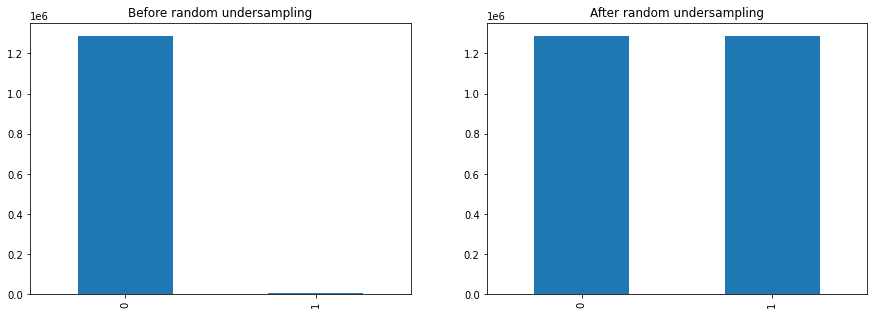

In [ ]:
transformer = Transformer()
transformer.fit(train_x, train_y)
train_x = transformer.encode_categorical(train_x)
train_x = transformer.transform(train_x, train_y)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before random undersampling')
pd.Series(train_y).value_counts().plot.bar(ax=ax1)

train_x, train_y = transformer.oversample(train_x, train_y)

ax2.set_title('After random undersampling')  
pd.Series(train_y).value_counts().plot.bar(ax=ax2)

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

MAX_ITER = 500
randomForest = RandomForestClassifier(n_estimators=400)
# parameters = {'max_depth':[3,5,10], 'min_samples_split' :[2,5,10]}
# classifier = GridSearchCV(randomForest,parameters,  scoring='accuracy', cv=5)

randomForest.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(n_estimators=400)

In [ ]:
from sklearn.metrics import confusion_matrix

print(randomForest.score(train_x, train_y))
print(confusion_matrix(train_y, randomForest.predict(train_x)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


[[1289169       0]
 [      0 1289169]]


In [ ]:
test_df = pd.read_csv('fraudTest.csv', index_col=0)
test_y = test_df['is_fraud']

In [ ]:
test_df, test_y = transformer.undersample(test_df, test_y)
test_df = transformer.encode_categorical(test_df)
test_df = transformer.transform(test_df, test_y)

print(randomForest.score(test_df, test_y))
confusion_matrix(test_y, randomForest.predict(test_df))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.5006993006993007


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


array([[2107,   38],
       [2104,   41]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(randomForest.predict(test_df), test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.98      0.50      0.66      4211
           1       0.02      0.52      0.04        79

    accuracy                           0.50      4290
   macro avg       0.50      0.51      0.35      4290
weighted avg       0.96      0.50      0.65      4290

